# Mini Project: Transfer Learning
### Student ID: 221111080
### Full Name: Chang Yu-Yuan

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import copy

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
from torch.optim import lr_scheduler
from sklearn import model_selection, metrics, preprocessing
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix #to create sparse matrices, which can speed up training

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Pre-Trained Model
## Model pre trained using CIFAR-10 dataset

In [2]:
# transfomr the CIFAR-10 dataset into tensors
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# download the CIFAR-10 dataset
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  
batch_size = 64
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

all_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Architecture for CNN
Input -> convolution layer (with activation function Relu) -> max pooling -> 2nd convolution layer(with Relu) -> max pooling
after flatten the image = > we have fully connected layers with softmax to output classification

1. Input Image Size: 224 x 224 x 3(channel) input to 1st Conv
1. First Conv output: 224 x 224 x 6 (Padding Used) -> ReLu
1. Max Pooling output: 112 x 112 x 6 (2 x 2 pool with stride = 2)
1. Second Conv output: 112 x 112 x 16 (Padding Used) -> ReLu
1. Max Pooling output: 56 x 56 x 16 (2 x 2 pool with stride = 2)
1. Flatten to fully coneected layer: 56 x 56 x 16 = 50176
1. 1st FCL: 50176 -> 120
1. 2nd FCL: 120 -> 84
1. 3rd FCL: 84 -> 10 (10 categories for CIFAR-10)
1. Finally we use Softmax to output the probability for each category.
Note: Use ReLu for Fully Connected Layer

In [3]:
# implement the CNN class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # max pook with a 2 x 2 window, stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # image 3 color channels, 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        # setup dropout to prvent overfitting
        # self.dropout = nn.Dropout(0.5)
        self.fully_connected1 = nn.Linear(16 * 56 * 56, 120)
        self.fully_connected2 = nn.Linear(120, 84)
        self.fully_connected3 = nn.Linear(84, 10)

    # Note that in forward pass, we can simply use x = model(x) to get the output
    # however, we didn't use nnsequential in order to implement transfer learning later
    # So we coded all process and the architecture for our NN is clear as well
    
    def forward(self, x):
        # convolutional layers with relu activation, followed by max pooling
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        # flatten the image for the fully connected layers
        x = x.view(-1, 16 * 56 * 56)
        x = F.relu(self.fully_connected1(x))
        x = F.relu(self.fully_connected2(x))
        x = self.fully_connected3(x)
        # x = F.log_softmax(self.fully_connected3(x), dim=1)
        return x
    
        # ------------------old 32 x 32 image size-----------------------------
        # # fully connected layers, we have 5x5 image size with 16 channels
        # # so when we flatten it, we get 16 * 5 * 5 vecotr tensor
        # self.fully_connected1 = nn.Linear(16 * 5 * 5, 120)
        # self.fully_connected2 = nn.Linear(120, 84)
        # # output layer is 10, one for each class
        # self.fully_connected3 = nn.Linear(84, 10)
        # ------------------old 32 x 32 image size-----------------------------
    


In [4]:
def CNN_train(model, train_loader, num_epochs, learning_rate=0.001):
    # we use adam optimizer for better performance
    # but we can also SGD as the optimizer
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # set up L2 regularization with weight_decay to prevent overfitting
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    total_steps = len(train_loader)
    loss_dict = {}
 
    # criterion = nn.NLLLoss() # when used, need to use F.log_softmax in the forward pass
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward and optimize
            # initialize the gradients to zero
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1)  == total_steps:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {round(loss.item(), 4)}')
        # store the loss for each epoch into the loss dictionary            
        loss_dict[epoch] = loss.item()
    print('Finished Training')
    return loss_dict

In [5]:
def eval_model(model, test_loader, n_class):
    with torch.no_grad():
        number_correct = 0
        number_samples = 0
        number_class_correct = [0 for i in range(n_class)]
        number_class_samples = [0 for i in range(n_class)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # get the prediction from the model(output is a 10 dimension vector with probabilities which was outputed from Softmax function)
            _, predicted = torch.max(outputs, 1)
            # Overall accuracy
            number_samples += labels.size(0)
            number_correct += (predicted == labels).sum().item()
            
            for i in range(labels.size(0)):
                label = labels[i]
                prediction = predicted[i]
                if (label == prediction):
                    number_class_correct[label] += 1
                number_class_samples[label] += 1
        accuracy = number_correct / number_samples
        print(f'Overall Accuracy: {round(accuracy*100,4)} %')

        # check the accuracy of each class in all classes
        for i in range(n_class):
            accuracy = number_class_correct[i] / number_class_samples[i]
            print(f'Accuracy of {all_classes[i]}: {round(accuracy*100,1)} %')

# start training setup

In [6]:
model1 = CNN().to(device)
loss_dict1 = CNN_train(model1, train_loader, num_epochs=10) # lr = 0.001 defaullt
torch.save(model1.state_dict(), "cnn_model1.pth")

Epoch [1/10], Step [782/782], Loss: 1.1839
Epoch [2/10], Step [782/782], Loss: 1.0405
Epoch [3/10], Step [782/782], Loss: 1.3404
Epoch [4/10], Step [782/782], Loss: 1.0601
Epoch [5/10], Step [782/782], Loss: 1.2708
Epoch [6/10], Step [782/782], Loss: 0.9931
Epoch [7/10], Step [782/782], Loss: 0.613
Epoch [8/10], Step [782/782], Loss: 1.2031
Epoch [9/10], Step [782/782], Loss: 0.6358
Epoch [10/10], Step [782/782], Loss: 0.5167
Finished Training


In [7]:
model2 = CNN().to(device)
loss_dict2 = CNN_train(model2, train_loader, num_epochs=20)
torch.save(model2.state_dict(), "cnn_model2.pth")

Epoch [1/20], Step [782/782], Loss: 1.1999
Epoch [2/20], Step [782/782], Loss: 1.4058
Epoch [3/20], Step [782/782], Loss: 1.0517
Epoch [4/20], Step [782/782], Loss: 1.1617
Epoch [5/20], Step [782/782], Loss: 0.8388
Epoch [6/20], Step [782/782], Loss: 0.7462
Epoch [7/20], Step [782/782], Loss: 0.5264
Epoch [8/20], Step [782/782], Loss: 0.2325
Epoch [9/20], Step [782/782], Loss: 0.3264
Epoch [10/20], Step [782/782], Loss: 0.6288
Epoch [11/20], Step [782/782], Loss: 0.1522
Epoch [12/20], Step [782/782], Loss: 0.1304
Epoch [13/20], Step [782/782], Loss: 0.6893
Epoch [14/20], Step [782/782], Loss: 0.3488
Epoch [15/20], Step [782/782], Loss: 0.0178
Epoch [16/20], Step [782/782], Loss: 0.0432
Epoch [17/20], Step [782/782], Loss: 0.3667
Epoch [18/20], Step [782/782], Loss: 0.1271
Epoch [19/20], Step [782/782], Loss: 0.3326
Epoch [20/20], Step [782/782], Loss: 0.1434
Finished Training


In [8]:
print(f"Result for model1: 10 epochs, 2 convolutional layers, 3 fully connected layers")
eval_model(model1, test_loader, 10)

Result for model1: 10 epochs, 2 convolutional layers, 3 fully connected layers
Overall Accuracy: 55.37 %
Accuracy of plane: 59.5 %
Accuracy of car: 67.1 %
Accuracy of bird: 47.3 %
Accuracy of cat: 44.4 %
Accuracy of deer: 45.9 %
Accuracy of dog: 40.9 %
Accuracy of frog: 58.9 %
Accuracy of horse: 60.6 %
Accuracy of ship: 67.0 %
Accuracy of truck: 62.1 %


In [9]:
print(f"Result for model2: 20 epochs, 2 convolutional layers, 3 fully connected layers")
eval_model(model2, test_loader, 10)

Result for model2: 20 epochs, 2 convolutional layers, 3 fully connected layers
Overall Accuracy: 55.36 %
Accuracy of plane: 58.7 %
Accuracy of car: 61.4 %
Accuracy of bird: 41.9 %
Accuracy of cat: 35.3 %
Accuracy of deer: 52.9 %
Accuracy of dog: 43.5 %
Accuracy of frog: 60.4 %
Accuracy of horse: 59.8 %
Accuracy of ship: 71.9 %
Accuracy of truck: 67.8 %


In [10]:
# print(f"Loss Function: Using NLLLoss instead of CrossEntropyLoss")
# print(f"Result for model1: 20 epochs, 2 convolutional layers, 3 fully connected layers")

# eval_model(model3, test_loader, 10)

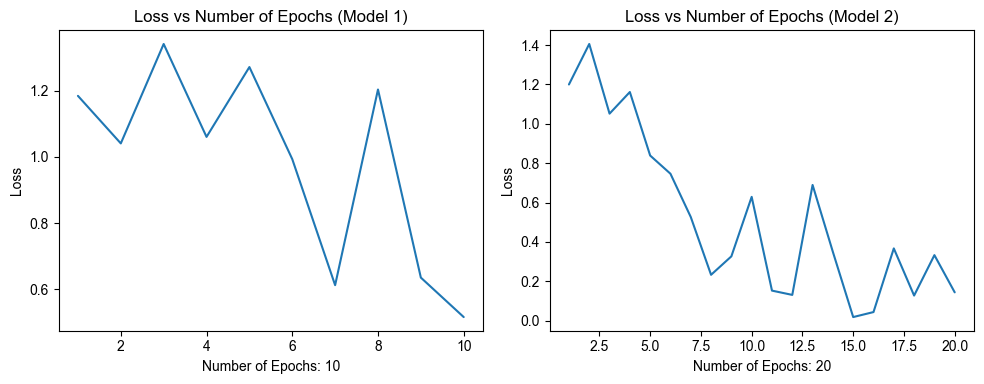

In [11]:
x1 = list(loss_dict1.keys())
# reindex
x1 = list(range(1, len(loss_dict1) + 1))
y1 = list(loss_dict1.values())

x2 = list(loss_dict2.keys())
# reindex
x2 = list(range(1, len(loss_dict2) + 1))
y2 = list(loss_dict2.values())

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.set(style="whitegrid")
sns.lineplot(ax=axes[0], x=x1, y=y1)
axes[0].set_title("Loss vs Number of Epochs (Model 1)")
axes[0].set_xlabel("Number of Epochs: 10")
axes[0].set_ylabel("Loss")

sns.lineplot(ax=axes[1], x=x2, y=y2)
axes[1].set_title("Loss vs Number of Epochs (Model 2)")
axes[1].set_xlabel("Number of Epochs: 20")
axes[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()

In [12]:
def load_new_batch(test_loader):
    # dataiter = iter(test_loader)
    images, labels = next(test_loader.__iter__())
    return images, labels

def show_predictions(model, test_loader, all_classes):
    images, labels = load_new_batch(test_loader)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # random sample 8 images
    indices = random.sample(range(len(images)), 8)
    
    fig, axes = plt.subplots(1, 8, figsize=(15, 2))
    axes = axes.flatten()
    for idx, ax in zip(indices, axes):
        img = images[idx].cpu()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the image data to 0 - 1
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        if labels[idx] == predicted[idx]:
            ax.set_title(f"Truth: {all_classes[labels[idx]]}\nPred: {all_classes[predicted[idx]]} (success)", color='green')
        else:
            ax.set_title(f"Truth: {all_classes[labels[idx]]}\nPred: {all_classes[predicted[idx]]} (Fail)", color='red')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

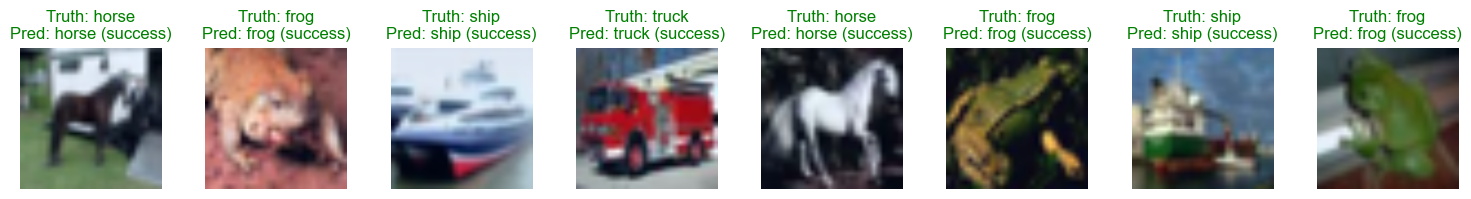

In [13]:
model2.load_state_dict(torch.load("cnn_model2.pth"))
model2.eval()
show_predictions(model2, test_loader, all_classes)

# Play around with different architecture
## CIFAR-10 Data set wiht 4Conv 5FC

In [14]:
# implement the CNN class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # image 3 color channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2)

        self.fully_connected1 = nn.Linear(64 * 14 * 14, 120)
        self.dropout1 = nn.Dropout(0.2) 
        self.fully_connected2 = nn.Linear(120, 90)
        self.dropout2 = nn.Dropout(0.2) 
        self.fully_connected3 = nn.Linear(90, 60)
        self.dropout3 = nn.Dropout(0.2) 
        self.fully_connected4 = nn.Linear(60, 45)
        self.dropout4 = nn.Dropout(0.2) 
        self.fully_connected5 = nn.Linear(45, 10)
        # ------------------new 224 x 224 image size-----------------------------

    def forward(self, x):

        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x= self.pool(F.relu(self.conv3(x)))
        x = self.avg_pool(F.relu(self.conv4(x)))

        # flatten the image for the fully connected layers
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fully_connected1(x))
        # x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.fully_connected2(x))
        x = self.dropout2(x)  # Apply dropout
        x = F.relu(self.fully_connected3(x))
        # x = self.dropout3(x)  # Apply dropout
        x = F.relu(self.fully_connected4(x))
        x = self.dropout4(x)  # Apply dropout
        x = self.fully_connected5(x)
        return x
    
def CNN_train(model, train_loader, num_epochs, learning_rate=0.001):
        total_steps = len(train_loader)
        loss_dict = {}
        # we can use stochastic gradient descent as the optimizer, learning rate is 0.001
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        # but in this case, we use adam optimizer for better performance
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # backward and optimize
                # initialize the gradients to zero
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if (i+1)  == total_steps:
                    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {round(loss.item(), 4)}')
            # store the loss for each epoch into the loss dictionary            
            loss_dict[epoch] = loss.item()
        print("Finished Training")
        return loss_dict



In [15]:
model3 = CNN().to(device)
loss_dict3 = CNN_train(model3, train_loader, num_epochs=12) # lr = 0.001 defaullt
torch.save(model3.state_dict(), "cnn_model3.pth")


Epoch [1/12], Step [782/782], Loss: 1.2546
Epoch [2/12], Step [782/782], Loss: 1.0135
Epoch [3/12], Step [782/782], Loss: 1.1088
Epoch [4/12], Step [782/782], Loss: 1.114
Epoch [5/12], Step [782/782], Loss: 0.9133
Epoch [6/12], Step [782/782], Loss: 0.9968
Epoch [7/12], Step [782/782], Loss: 0.8308
Epoch [8/12], Step [782/782], Loss: 0.5567
Epoch [9/12], Step [782/782], Loss: 0.6588
Epoch [10/12], Step [782/782], Loss: 0.5914
Epoch [11/12], Step [782/782], Loss: 0.2061
Epoch [12/12], Step [782/782], Loss: 0.4223
Finished Training


Data: CIFAR-10
Model3 :Result for Using 4 Conv layers and 5 FC layers with 120, 90, 60, 45, 10 neurons
Overall Accuracy: 67.85 %
Accuracy of plane: 79.3 %
Accuracy of car: 74.6 %
Accuracy of bird: 47.2 %
Accuracy of cat: 48.8 %
Accuracy of deer: 67.9 %
Accuracy of dog: 57.3 %
Accuracy of frog: 68.0 %
Accuracy of horse: 78.7 %
Accuracy of ship: 76.8 %
Accuracy of truck: 79.9 %


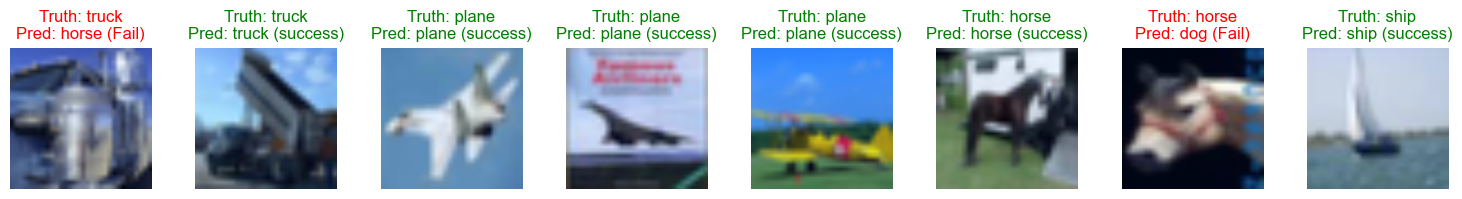

In [16]:
print(f"Data: CIFAR-10")
print(f"Model3 :Result for Using 4 Conv layers and 5 FC layers with 120, 90, 60, 45, 10 neurons")
eval_model(model3, test_loader, 10)
show_predictions(model3, test_loader, all_classes)

# Use model3 for transfer learning for NEW data set(Ants vs Bees)

In [17]:
data_dir = "data/hymenoptera_data"
save_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

os.system(f"wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P {save_dir}")
import zipfile
with zipfile.ZipFile(f"{save_dir}/hymenoptera_data.zip", "r") as zip_ref:
    zip_ref.extractall(save_dir)
os.remove(f"{save_dir}/hymenoptera_data.zip")

--2025-09-10 20:03:38--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.169.137.100, 3.169.137.77, 3.169.137.102, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.169.137.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

     0K .......... .......... .......... .......... ..........  0% 3.17M 14s
    50K .......... .......... .......... .......... ..........  0% 1.77M 20s
   100K .......... .......... .......... .......... ..........  0% 1.02M 28s
   150K .......... .......... .......... .......... ..........  0% 5.28M 23s
   200K .......... .......... .......... .......... ..........  0% 1.42M 25s
   250K .......... .......... .......... .......... ..........  0% 54.9M 21s
   300K .......... .......... .......... .......... ..........  0% 14.3M 18s
   350K .......... .......... .......... .......... .

In [18]:
# Import Data
sets = ["train", "val"]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 4

image_data_sets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_data_sets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ["train", "val"]}
# our data
train_loader2 = dataloaders["train"]
test_loader2 = dataloaders["val"]

dataset_sizes = {x: len(image_data_sets[x]) for x in ['train', 'val']}
# get all classes from the dataset
all_classes2 = image_data_sets['train'].classes
print(all_classes2)

['ants', 'bees']


In [19]:
def transfer_learning_train(model, train_loader, num_epochs=20, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    total_steps = len(train_loader)
    loss_dict = {}
    # we can use stochastic gradient descent as the optimizer, learning rate is 0.001
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # but in this case, we stick on using adam optimizer
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate((train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # backward and optimize
            # initialize the gradients to zero
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()
            if (i+1)  == total_steps:
                print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {round(loss.item(), 4)}")

            
        loss_dict[epoch] = loss.item()
    print("Finished Training")
    return loss_dict

def eval_model(model, test_loader, n_class):
    with torch.no_grad():
        number_correct = 0
        number_samples = 0
        number_class_correct = [0 for i in range(n_class)]
        number_class_samples = [0 for i in range(n_class)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # get the prediction from the model(output is a 10 dimension vector with probabilities which was outputed from Softmax function)
            _, predicted = torch.max(outputs, 1)
            # Overall accuracy
            number_samples += labels.size(0)
            number_correct += (predicted == labels).sum().item()
            
            for i in range(labels.size(0)):
                label = labels[i]
                prediction = predicted[i]
                if (label == prediction):
                    number_class_correct[label] += 1
                number_class_samples[label] += 1
        accuracy = number_correct / number_samples
        print(f"Overall Accuracy: {round(accuracy*100,4)} %")

        # check the accuracy of each class in all classes
        for i in range(n_class):
            accuracy = number_class_correct[i] / number_class_samples[i]
            print(f"Accuracy of {all_classes2[i]}: {round(accuracy*100,1)} %")

In [20]:
def load_new_batch(test_loader):
    # dataiter = iter(test_loader)
    images, labels = next(test_loader.__iter__())
    return images, labels

def show_predictions(model, test_loader, all_classes, iter=4):
    for i in range(iter):
        images, labels = load_new_batch(test_loader)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        indices = random.sample(range(len(images)), 2)
        
        fig, axes = plt.subplots(1, 2, figsize=(4, 2))
        axes = axes.flatten()
        for idx, ax in zip(indices, axes):
            img = images[idx].cpu()
            img = (img - img.min()) / (img.max() - img.min())  # Normalize the image data to 0 - 1
            npimg = img.numpy()
            ax.imshow(np.transpose(npimg, (1, 2, 0)))
            if labels[idx] == predicted[idx]:
                ax.set_title(f"Truth: {all_classes[labels[idx]]}\nPred: {all_classes[predicted[idx]]} (success)", color='green')
            else:
                ax.set_title(f"Truth: {all_classes[labels[idx]]}\nPred: {all_classes[predicted[idx]]} (Fail)", color='red')
            ax.axis("off")
        plt.tight_layout()
        plt.show()

In [21]:
model3.load_state_dict(torch.load("cnn_model3.pth"))
model3.to(device)

for parameters in model3.parameters():
    parameters.requires_grad = False

number_final_layer = model3.fully_connected5.in_features
transfer_learning_model = copy.deepcopy(model3)
transfer_learning_model.fully_connected5 = nn.Linear(number_final_layer, 2)  # New Dataset has 2 classes
transfer_learning_model.to(device)

# transfer_learning_model = CNN().to(device)
loss_dict_transfer_learning = transfer_learning_train(transfer_learning_model,train_loader2, num_epochs=20, learning_rate=0.001)
torch.save(transfer_learning_model.state_dict(), "transfer_learning_model.pth")


Epoch [1/20], Step [61/61], Loss: 0.7142
Epoch [2/20], Step [61/61], Loss: 0.3956
Epoch [3/20], Step [61/61], Loss: 0.6915
Epoch [4/20], Step [61/61], Loss: 0.9362
Epoch [5/20], Step [61/61], Loss: 1.0488
Epoch [6/20], Step [61/61], Loss: 0.567
Epoch [7/20], Step [61/61], Loss: 0.879
Epoch [8/20], Step [61/61], Loss: 0.7052
Epoch [9/20], Step [61/61], Loss: 0.8668
Epoch [10/20], Step [61/61], Loss: 0.7767
Epoch [11/20], Step [61/61], Loss: 0.5758
Epoch [12/20], Step [61/61], Loss: 0.7047
Epoch [13/20], Step [61/61], Loss: 0.5155
Epoch [14/20], Step [61/61], Loss: 0.7341
Epoch [15/20], Step [61/61], Loss: 0.747
Epoch [16/20], Step [61/61], Loss: 0.6824
Epoch [17/20], Step [61/61], Loss: 0.6993
Epoch [18/20], Step [61/61], Loss: 0.7905
Epoch [19/20], Step [61/61], Loss: 0.6069
Epoch [20/20], Step [61/61], Loss: 0.971
Finished Training


Data: Hymenoptera Dataset(Bee and Ant)
Transfer Learning using CIFAR-10 pre-trained model: 20 epochs, 2 classes
Overall Accuracy: 52.9412 %
Accuracy of ants: 25.7 %
Accuracy of bees: 75.9 %


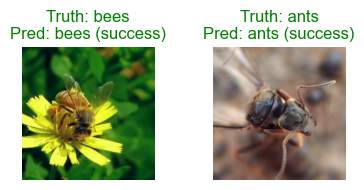

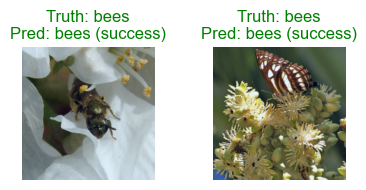

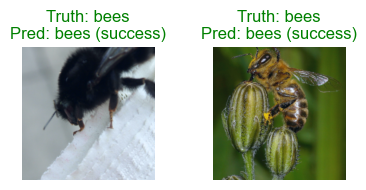

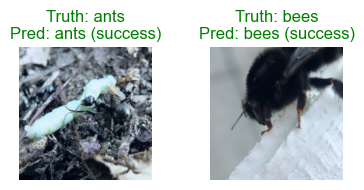

In [22]:
transfer_learning_model.load_state_dict(torch.load("transfer_learning_model.pth"))
transfer_learning_model.eval()
print(f"Data: Hymenoptera Dataset(Bee and Ant)")
print(f"Transfer Learning using CIFAR-10 pre-trained model: 20 epochs, 2 classes")
eval_model(transfer_learning_model, test_loader2, 2)
show_predictions(transfer_learning_model, test_loader2, all_classes2, 4)

In [23]:
model3.load_state_dict(torch.load("cnn_model3.pth"))
model3.to(device)

for parameters in model3.parameters():
    parameters.requires_grad = False

number_final_layer = model3.fully_connected5.in_features
transfer_learning_model = copy.deepcopy(model3)
transfer_learning_model.fully_connected5 = nn.Linear(number_final_layer, 2)  # New Dataset has 2 classes
transfer_learning_model.to(device)

# transfer_learning_model = CNN().to(device)
loss_dict_transfer_learning = transfer_learning_train(transfer_learning_model,train_loader2, num_epochs=20, learning_rate=0.001)
torch.save(transfer_learning_model.state_dict(), "transfer_learning_model.pth")


Epoch [1/20], Step [61/61], Loss: 0.9111
Epoch [2/20], Step [61/61], Loss: 0.6275
Epoch [3/20], Step [61/61], Loss: 0.968
Epoch [4/20], Step [61/61], Loss: 0.9645
Epoch [5/20], Step [61/61], Loss: 1.026
Epoch [6/20], Step [61/61], Loss: 0.6408
Epoch [7/20], Step [61/61], Loss: 0.6271
Epoch [8/20], Step [61/61], Loss: 0.6996
Epoch [9/20], Step [61/61], Loss: 0.6524
Epoch [10/20], Step [61/61], Loss: 0.9161
Epoch [11/20], Step [61/61], Loss: 0.9426
Epoch [12/20], Step [61/61], Loss: 0.7401
Epoch [13/20], Step [61/61], Loss: 0.5859
Epoch [14/20], Step [61/61], Loss: 0.7591
Epoch [15/20], Step [61/61], Loss: 0.6885
Epoch [16/20], Step [61/61], Loss: 0.6957
Epoch [17/20], Step [61/61], Loss: 0.6962
Epoch [18/20], Step [61/61], Loss: 0.7509
Epoch [19/20], Step [61/61], Loss: 0.5957
Epoch [20/20], Step [61/61], Loss: 0.7384
Finished Training


Data: Hymenoptera Dataset(Bee and Ant)
Transfer Learning using CIFAR-10 pre-trained model: 20 epochs, 2 classes
Overall Accuracy: 50.9804 %
Accuracy of ants: 20.0 %
Accuracy of bees: 77.1 %


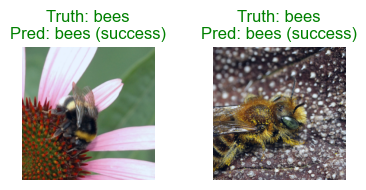

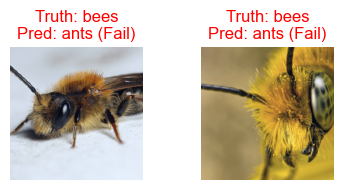

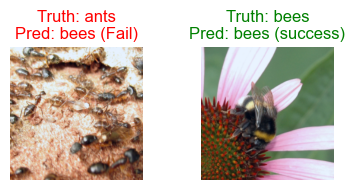

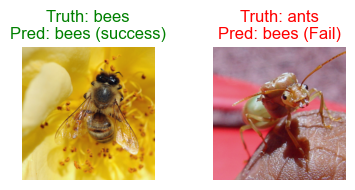

In [24]:
transfer_learning_model.load_state_dict(torch.load("transfer_learning_model.pth"))
transfer_learning_model.eval()
print(f"Data: Hymenoptera Dataset(Bee and Ant)")
print(f"Transfer Learning using CIFAR-10 pre-trained model: 20 epochs, 2 classes")
eval_model(transfer_learning_model, test_loader2, 2)
show_predictions(transfer_learning_model, test_loader2, all_classes2, 4)

# Use public pre-trained ResNet18 for transfer learning

In [25]:
from torchvision.models import ResNet18_Weights
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for parameters in resnet_model.parameters():
    parameters.requires_grad = False

number_final_layer2 = resnet_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
resnet_model.fc = nn.Linear(number_final_layer2, 2)

resnet_model = resnet_model.to(device)
loss_dict_transfer_learning2 = transfer_learning_train(resnet_model,train_loader2, num_epochs=20, learning_rate=0.001)
torch.save(resnet_model.state_dict(), "resnet_model.pth")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/chang.yy/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:08<00:00, 5.49MB/s]


Epoch [1/20], Step [61/61], Loss: 0.6556
Epoch [2/20], Step [61/61], Loss: 0.4181
Epoch [3/20], Step [61/61], Loss: 0.4036
Epoch [4/20], Step [61/61], Loss: 0.1018
Epoch [5/20], Step [61/61], Loss: 0.0792
Epoch [6/20], Step [61/61], Loss: 0.0991
Epoch [7/20], Step [61/61], Loss: 0.3309
Epoch [8/20], Step [61/61], Loss: 0.4094
Epoch [9/20], Step [61/61], Loss: 0.7
Epoch [10/20], Step [61/61], Loss: 0.1419
Epoch [11/20], Step [61/61], Loss: 0.8812
Epoch [12/20], Step [61/61], Loss: 0.2757
Epoch [13/20], Step [61/61], Loss: 0.1441
Epoch [14/20], Step [61/61], Loss: 0.0729
Epoch [15/20], Step [61/61], Loss: 0.5446
Epoch [16/20], Step [61/61], Loss: 0.1092
Epoch [17/20], Step [61/61], Loss: 0.296
Epoch [18/20], Step [61/61], Loss: 0.0839
Epoch [19/20], Step [61/61], Loss: 2.781
Epoch [20/20], Step [61/61], Loss: 0.4319
Finished Training


Data: Hymenoptera Dataset(Bee and Ant)
Transfer Learning using pre-trained ResNet18 model, 20 epochs, 2 classes
Overall Accuracy: 93.4641 %
Accuracy of ants: 97.1 %
Accuracy of bees: 90.4 %


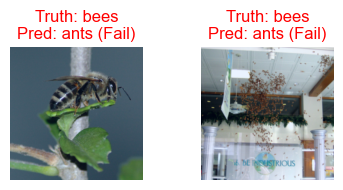

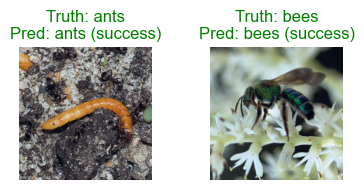

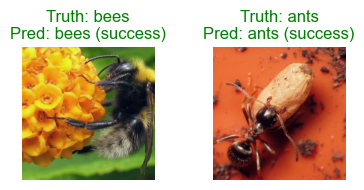

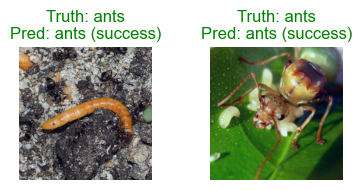

In [26]:
resnet_model.load_state_dict(torch.load("resnet_model.pth"))
resnet_model.eval()
print(f"Data: Hymenoptera Dataset(Bee and Ant)")
print("Transfer Learning using pre-trained ResNet18 model, 20 epochs, 2 classes")
eval_model(resnet_model, test_loader2, 2)
show_predictions(resnet_model, test_loader2, all_classes2, 4)

## Ants and Bee without Transfer Learning
## New architecture with 4 Conv Layers + 5 FC Layers

In [27]:
# Import Data
data_dir = "data/hymenoptera_data"
sets = ["train", "val"]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), 
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 5])
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 5])
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 4

image_data_sets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_data_sets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ["train", "val"]}
# our data
train_loader2 = dataloaders["train"]
test_loader2 = dataloaders["val"]

dataset_sizes = {x: len(image_data_sets[x]) for x in ["train", "val"]}
# get all classes from the dataset
all_classes = image_data_sets["train"].classes

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # image 3 color channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 64, 7, padding=3)

        self.fully_connected1 = nn.Linear(64 * 14 * 14, 120)
        self.fully_connected2 = nn.Linear(120, 90)
        self.fully_connected3 = nn.Linear(90, 60)
        self.fully_connected4 = nn.Linear(60, 45)
        self.fully_connected5 = nn.Linear(45, 2)
        # ------------------new 224 x 224 image size-----------------------------

    def forward(self, x):
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x= self.pool(F.relu(self.conv3(x)))
        x = self.avg_pool(F.relu(self.conv4(x)))

        # flatten the image for the fully connected layers
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fully_connected1(x))
        x = F.relu(self.fully_connected2(x))
        x = F.relu(self.fully_connected3(x))
        x = F.relu(self.fully_connected4(x))
        x = self.fully_connected5(x)
        return x
    
def eval_model(model, test_loader, n_class):
    with torch.no_grad():
        number_correct = 0
        number_samples = 0
        number_class_correct = [0 for i in range(n_class)]
        number_class_samples = [0 for i in range(n_class)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # get the prediction from the model(output is a 10 dimension vector with probabilities which was outputed from Softmax function)
            _, predicted = torch.max(outputs, 1)
            # Overall accuracy
            number_samples += labels.size(0)
            number_correct += (predicted == labels).sum().item()
            
            for i in range(labels.size(0)):
                label = labels[i]
                prediction = predicted[i]
                if (label == prediction):
                    number_class_correct[label] += 1
                number_class_samples[label] += 1
        accuracy = number_correct / number_samples
        print(f"Overall Accuracy: {round(accuracy*100,4)} %")

        # check the accuracy of each class in all classes
        for i in range(n_class):
            accuracy = number_class_correct[i] / number_class_samples[i]
            print(f"Accuracy of {all_classes[i]}: {round(accuracy*100,1)} %")

### Run model

In [29]:
model4 = CNN().to(device)
loss_dict4 = CNN_train(model4, train_loader2, num_epochs=20) # lr = 0.001 defaullt
torch.save(model4.state_dict(), "cnn_model4.pth")

Epoch [1/20], Step [61/61], Loss: 0.7181
Epoch [2/20], Step [61/61], Loss: 0.6935
Epoch [3/20], Step [61/61], Loss: 0.7224
Epoch [4/20], Step [61/61], Loss: 0.6873
Epoch [5/20], Step [61/61], Loss: 0.6933
Epoch [6/20], Step [61/61], Loss: 0.6932
Epoch [7/20], Step [61/61], Loss: 0.7076
Epoch [8/20], Step [61/61], Loss: 0.6997
Epoch [9/20], Step [61/61], Loss: 0.697
Epoch [10/20], Step [61/61], Loss: 0.7011
Epoch [11/20], Step [61/61], Loss: 0.6932
Epoch [12/20], Step [61/61], Loss: 0.7154
Epoch [13/20], Step [61/61], Loss: 0.6952
Epoch [14/20], Step [61/61], Loss: 0.6932
Epoch [15/20], Step [61/61], Loss: 0.6932
Epoch [16/20], Step [61/61], Loss: 0.6997
Epoch [17/20], Step [61/61], Loss: 0.6964
Epoch [18/20], Step [61/61], Loss: 0.6932
Epoch [19/20], Step [61/61], Loss: 0.6904
Epoch [20/20], Step [61/61], Loss: 0.7147
Finished Training


In [30]:
print(f"Data: Hymenoptera, Ants vs Bees")
print(f"Result using 4 Conv layers and 5 FC layers with 120, 90, 60, 45, 2 neurons")
eval_model(model4, test_loader2, 2)

Data: Hymenoptera, Ants vs Bees
Result using 4 Conv layers and 5 FC layers with 120, 90, 60, 45, 2 neurons
Overall Accuracy: 45.7516 %
Accuracy of ants: 100.0 %
Accuracy of bees: 0.0 %


# What about using ResNet18 transfer learning to train for aother data sets?
# Try Other Data Set: Alzheimer's disease

In [ ]:
# # dowlaond dataset
# save_dir = "data"
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

# os.system(f'kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images -p {save_dir}')
# import zipfile
# with zipfile.ZipFile(f"{save_dir}/alzheimers-dataset-4-class-of-images.zip", "r") as zip_ref:
#     zip_ref.extractall(save_dir)
# os.remove(f"{save_dir}/alzheimers-dataset-4-class-of-images.zip")

sh: kaggle: command not found


FileNotFoundError: [Errno 2] No such file or directory: 'data/alzheimers-dataset-4-class-of-images.zip'

In [32]:
data_dir = "data/Alzheimer_s Dataset"
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 5])
    ]),
}
batch_size = 32

image_data_sets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(image_data_sets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ["train", "test"]}
# our data
train_loader2 = dataloaders["train"]
test_loader2 = dataloaders["test"]

dataset_sizes = {x: len(image_data_sets[x]) for x in ['train', 'test']}
# get all classes from the dataset
all_classes = image_data_sets['train'].classes

In [33]:
# Architecture 1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # image 3 color channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2)

        self.fully_connected1 = nn.Linear(64 * 14 * 14, 120)
        self.dropout1 = nn.Dropout(0.2) 
        self.fully_connected2 = nn.Linear(120, 90)
        self.dropout2 = nn.Dropout(0.2) 
        self.fully_connected3 = nn.Linear(90, 60)
        self.dropout3 = nn.Dropout(0.2) 
        self.fully_connected4 = nn.Linear(60, 45)
        self.dropout4 = nn.Dropout(0.2) 
        self.fully_connected5 = nn.Linear(45, 4)
        # ------------------new 224 x 224 image size-----------------------------

    def forward(self, x):
        x= self.pool(F.leaky_relu(self.conv1(x)))
        x= self.pool(F.leaky_relu(self.conv2(x)))
        x= self.pool(F.leaky_relu(self.conv3(x)))
        x = self.avg_pool(F.leaky_relu(self.conv4(x)))

        # flatten the image for the fully connected layers
        x = x.view(-1, 64 * 14 * 14)
        x = F.leaky_relu(self.fully_connected1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fully_connected2(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fully_connected3(x))
        x = self.dropout3(x)
        x = F.leaky_relu(self.fully_connected4(x))
        x = self.dropout4(x)
        x = self.fully_connected5(x)
        return x

In [34]:
model5 = CNN().to(device)
loss_dict5 = CNN_train(model5, train_loader2, num_epochs=20) # lr = 0.001 defaullt
torch.save(model5.state_dict(), "cnn_model5.pth")

Epoch [1/20], Step [161/161], Loss: 1.0563
Epoch [2/20], Step [161/161], Loss: 1.0286
Epoch [3/20], Step [161/161], Loss: 0.9809
Epoch [4/20], Step [161/161], Loss: 1.1342
Epoch [5/20], Step [161/161], Loss: 1.0442
Epoch [6/20], Step [161/161], Loss: 0.317
Epoch [7/20], Step [161/161], Loss: 0.9263
Epoch [8/20], Step [161/161], Loss: 1.1209
Epoch [9/20], Step [161/161], Loss: 0.3651
Epoch [10/20], Step [161/161], Loss: 1.4486
Epoch [11/20], Step [161/161], Loss: 0.8586
Epoch [12/20], Step [161/161], Loss: 0.5489
Epoch [13/20], Step [161/161], Loss: 0.855
Epoch [14/20], Step [161/161], Loss: 1.2696
Epoch [15/20], Step [161/161], Loss: 1.1033
Epoch [16/20], Step [161/161], Loss: 0.5006
Epoch [17/20], Step [161/161], Loss: 1.1646
Epoch [18/20], Step [161/161], Loss: 0.1672
Epoch [19/20], Step [161/161], Loss: 0.7372
Epoch [20/20], Step [161/161], Loss: 1.1451
Finished Training


In [35]:
print(f"Alzheimer_s Result without transfer learning")
print(f"Result using 4 Conv layers and 5 FC layers with 120, 90, 60, 45, 2 neurons")
eval_model(model5, test_loader2, 4)

Alzheimer_s Result without transfer learning
Result using 4 Conv layers and 5 FC layers with 120, 90, 60, 45, 2 neurons
Overall Accuracy: 55.2776 %
Accuracy of MildDemented: 0.0 %
Accuracy of ModerateDemented: 0.0 %
Accuracy of NonDemented: 74.7 %
Accuracy of VeryMildDemented: 51.1 %


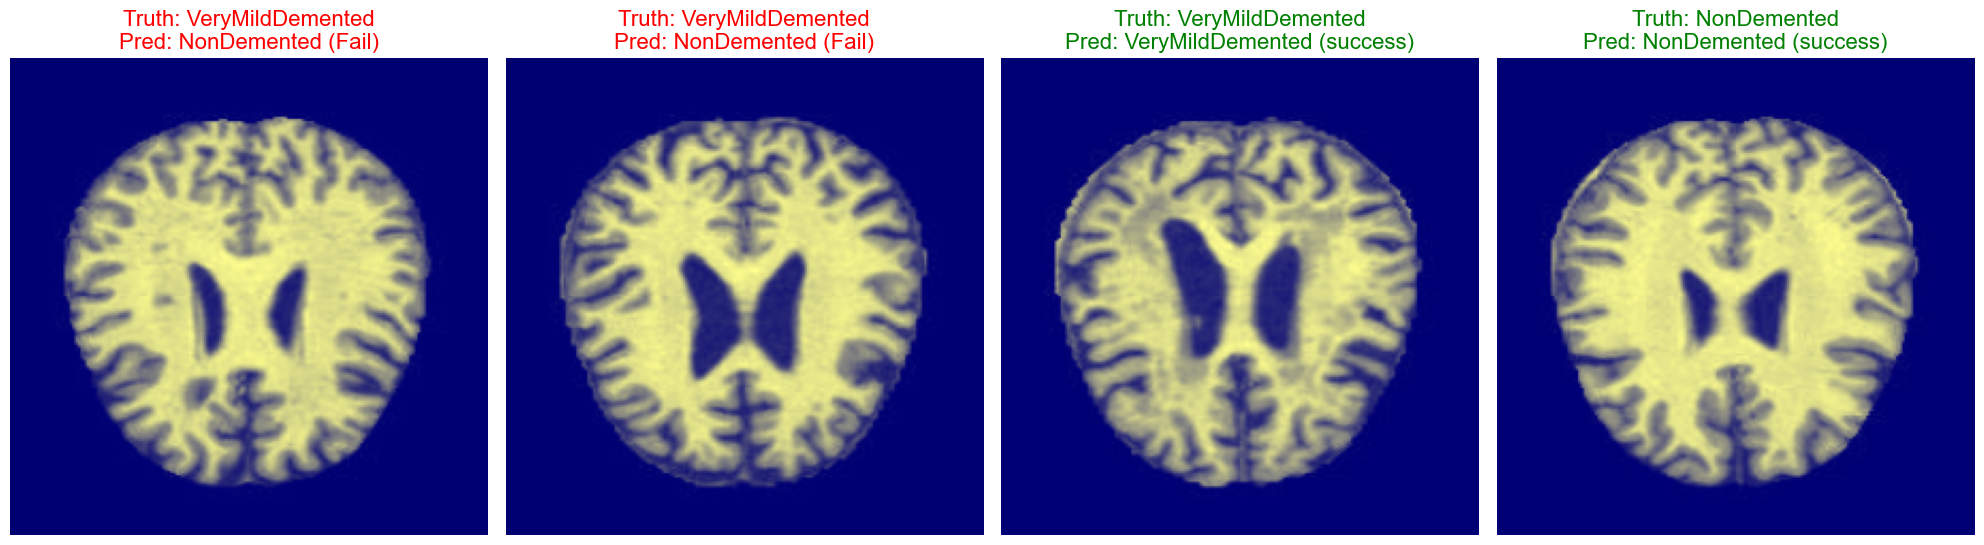

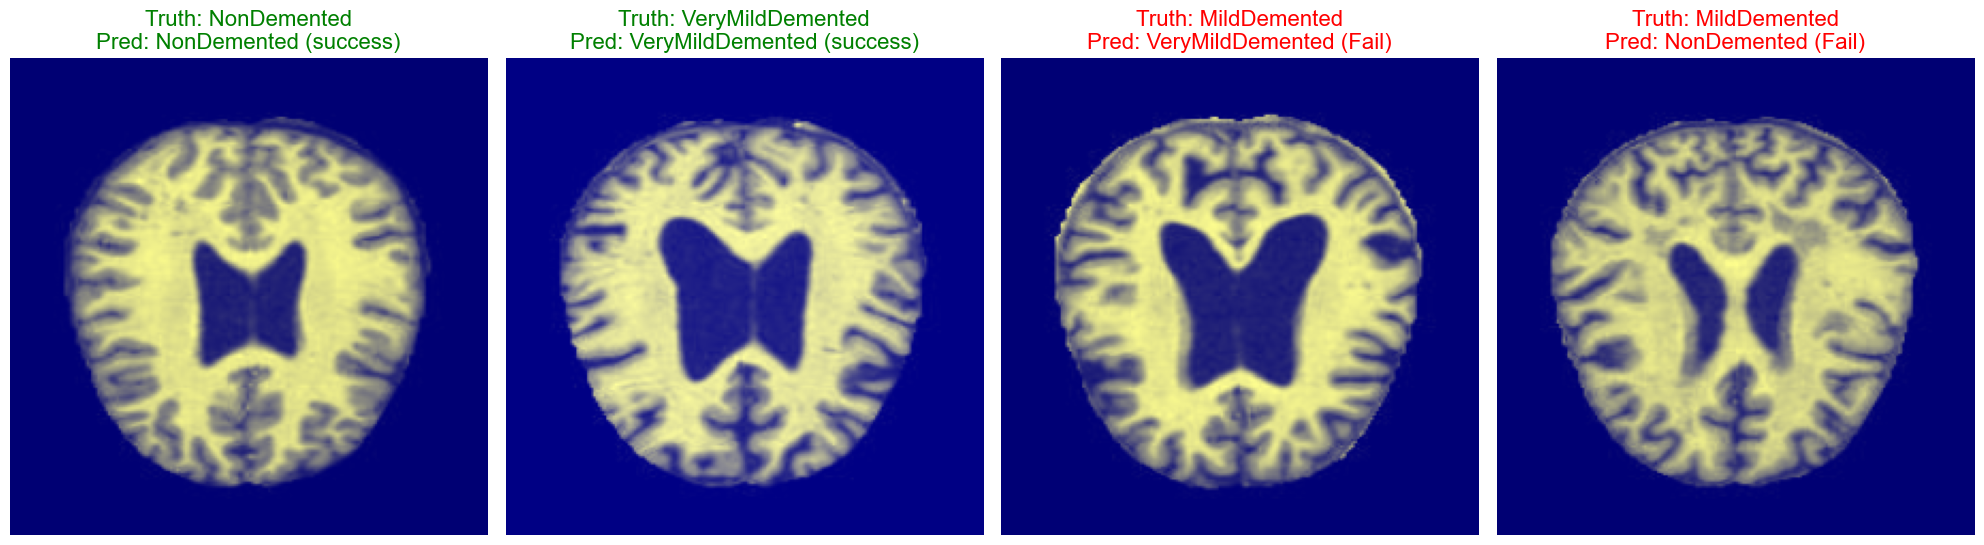

In [36]:
def show_predictions(model, test_loader, all_classes, iter=4):
    for i in range(iter):
        images, labels = load_new_batch(test_loader)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        indices = random.sample(range(len(images)), 4)
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 16))
        axes = axes.flatten()
        for idx, ax in zip(indices, axes):
            img = images[idx].cpu()
            img = (img - img.min()) / (img.max() - img.min())  # Normalize the image data to 0 - 1
            npimg = img.numpy()
            ax.imshow(np.transpose(npimg, (1, 2, 0)))
            if labels[idx] == predicted[idx]:
                ax.set_title(f"Truth: {all_classes[labels[idx]]}\nPred: {all_classes[predicted[idx]]} (success)", color='green', fontsize=16)
            else:
                ax.set_title(f"Truth: {all_classes[labels[idx]]}\nPred: {all_classes[predicted[idx]]} (Fail)", color='red', fontsize=16)
            ax.axis("off")
        plt.tight_layout()
        plt.show()

show_predictions(model5, test_loader2, all_classes, 2)


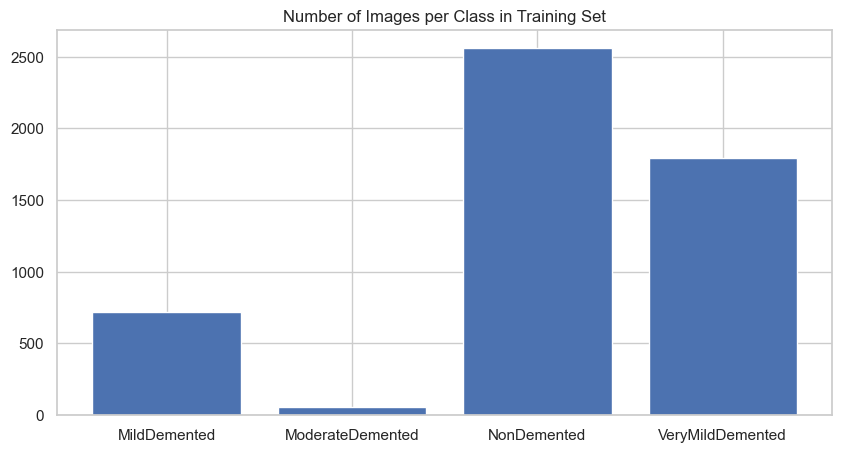

In [37]:
from collections import Counter
data_counts = {}
train_class_counts = Counter([label for _, label in train_loader2.dataset.samples])
sorted_train_class_counts = dict(sorted(train_class_counts.items()))
label, counts = zip(*sorted_train_class_counts.items())
plt.figure(figsize=(10, 5))
plt.bar(label, counts)
plt.title("Number of Images per Class in Training Set")
plt.xticks(label, all_classes)
plt.show()

## Use ResNet18 for transfer learning on Alzheimer's disease data

## Increase Data Augmentation

In [38]:
data_dir = "data/Alzheimer_s Dataset"
sets = ["train", "test"]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 5])
    ]),
}
batch_size = 32

image_data_sets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(image_data_sets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ["train", "test"]}
# our data
train_loader2 = dataloaders["train"]
test_loader2 = dataloaders["test"]

dataset_sizes = {x: len(image_data_sets[x]) for x in ["train", "test"]}
# get all classes from the dataset
all_classes = image_data_sets["train"].classes

In [39]:
resnet_model2 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for parameters in resnet_model2.parameters():
    parameters.requires_grad = False

number_final_layer2 = resnet_model2.fc.in_features
resnet_model2.fc = nn.Linear(number_final_layer2, 4)

resnet_model2 = resnet_model2.to(device)
loss_dict_transfer_learning3 = transfer_learning_train(resnet_model2,train_loader2, num_epochs=20, learning_rate=0.001)
print()

torch.save(resnet_model2.state_dict(), "resnet_model2.pth")


Epoch [1/20], Step [161/161], Loss: 0.4966
Epoch [2/20], Step [161/161], Loss: 0.7412
Epoch [3/20], Step [161/161], Loss: 0.7146
Epoch [4/20], Step [161/161], Loss: 0.983
Epoch [5/20], Step [161/161], Loss: 2.1349
Epoch [6/20], Step [161/161], Loss: 2.6089
Epoch [7/20], Step [161/161], Loss: 5.025
Epoch [8/20], Step [161/161], Loss: 0.9159
Epoch [9/20], Step [161/161], Loss: 1.1915
Epoch [10/20], Step [161/161], Loss: 0.897
Epoch [11/20], Step [161/161], Loss: 0.6156
Epoch [12/20], Step [161/161], Loss: 0.8606
Epoch [13/20], Step [161/161], Loss: 2.7657
Epoch [14/20], Step [161/161], Loss: 0.9791
Epoch [15/20], Step [161/161], Loss: 0.6455
Epoch [16/20], Step [161/161], Loss: 1.4246
Epoch [17/20], Step [161/161], Loss: 0.9213
Epoch [18/20], Step [161/161], Loss: 0.5547
Epoch [19/20], Step [161/161], Loss: 0.7254
Epoch [20/20], Step [161/161], Loss: 0.6712
Finished Training



Alzheimer_s Result without transfer learning
Result with transfer learning using pre-trained model: resnet18
Overall Accuracy: 54.0266 %
Accuracy of MildDemented: 38.5 %
Accuracy of ModerateDemented: 0.0 %
Accuracy of NonDemented: 80.3 %
Accuracy of VeryMildDemented: 24.1 %


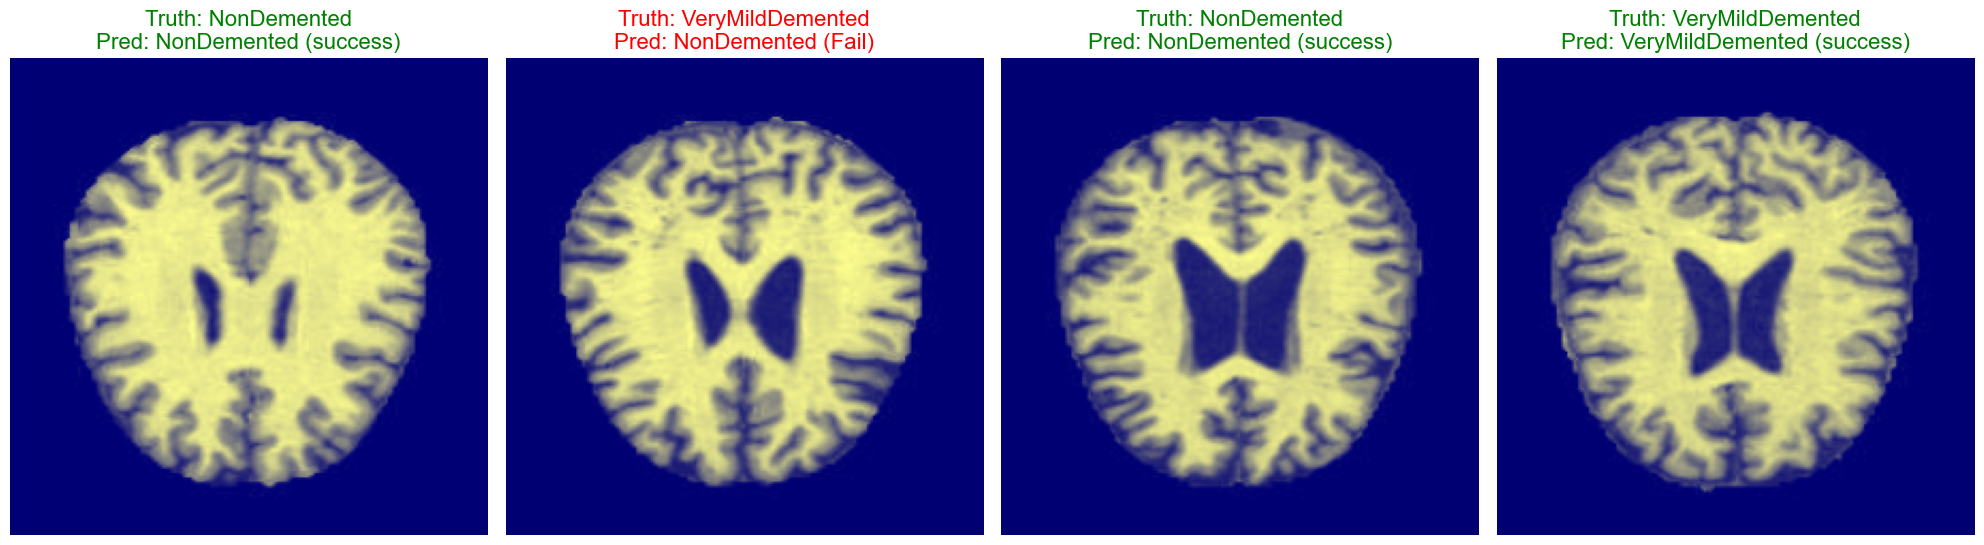

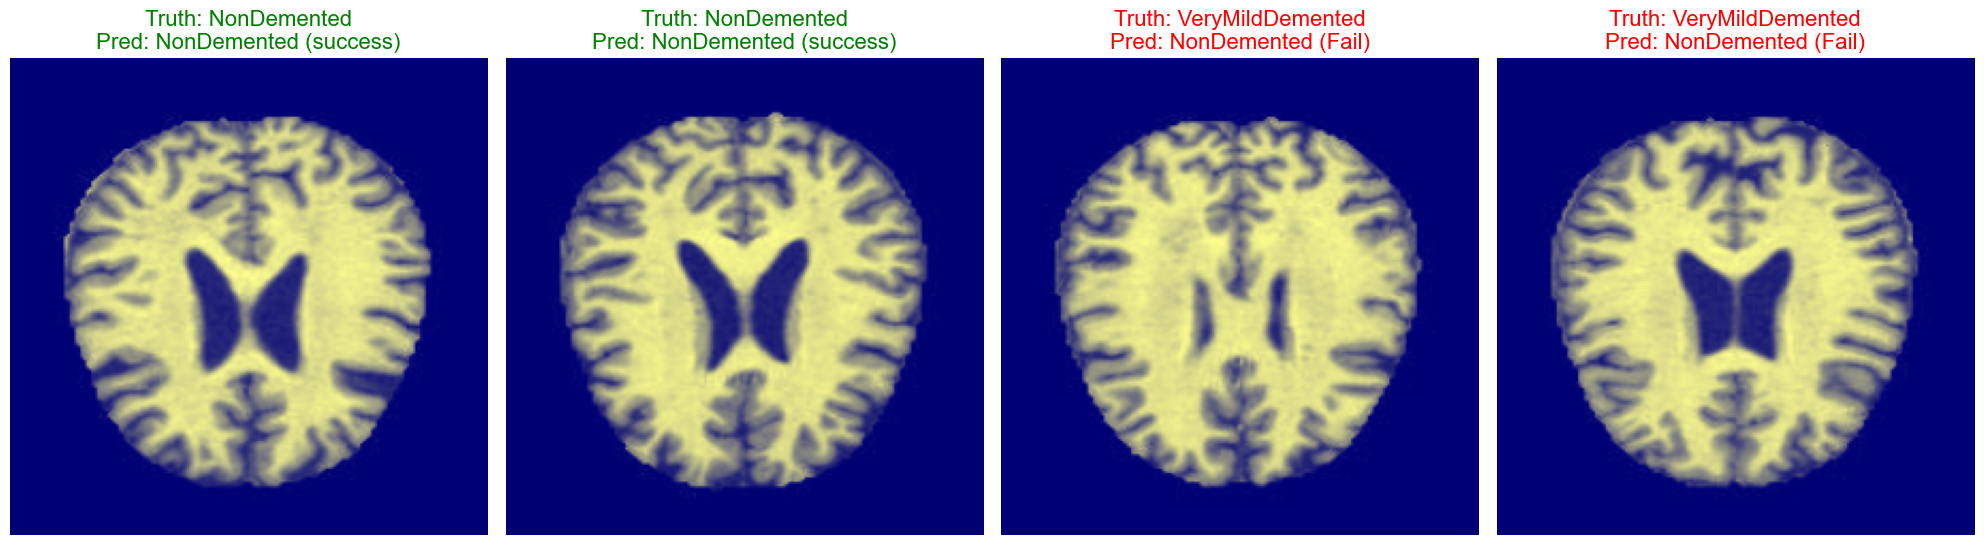

In [40]:
print(f"Alzheimer_s Result without transfer learning")
print(f"Result with transfer learning using pre-trained model: resnet18")
eval_model(resnet_model2, test_loader2, 4)
show_predictions(resnet_model2, test_loader2, all_classes, 2)